In [10]:
import xarray_beam as xbeam
import xarray
from apache_beam.options.pipeline_options import PipelineOptions
import apache_beam as beam
import pandas as pd
import numpy as np   

ds = xarray.open_zarr('gs://era5_preprocess/64x32/2018-01-01_2023-01-01.zarr', chunks=None)
print(ds.nbytes / (10**9))

0.512694456


In [6]:
print(ds)

<xarray.Dataset>
Dimensions:                                           (time: 93544,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 ...
    10m_wind_speed                                    (time, longitude, latitude) float32 ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 ...
    2m_temperature           

In [28]:
new_dataset = ds.isel(latitude=lat_indices, longitude=lon_indices)

In [29]:
print(new_dataset)

<xarray.Dataset>
Dimensions:                                           (time: 93544,
                                                       longitude: 14,
                                                       latitude: 33, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 21.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 121...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 ...
    10m_wind_speed                                    (time, longitude, latitude) float32 ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 ...
    2m_temperature           

In [13]:
variable = ['geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity']
arr = ds[variable]

In [14]:
print(arr)

<xarray.Dataset>
Dimensions:              (time: 849, level: 13, latitude: 28, longitude: 28)
Coordinates:
  * latitude             (latitude) float32 39.0 38.75 38.5 ... 32.75 32.5 32.25
  * level                (level) int64 50 100 150 200 250 ... 700 850 925 1000
  * longitude            (longitude) float32 124.2 124.5 124.8 ... 130.8 131.0
  * time                 (time) datetime64[ns] 2021-01-01 ... 2021-08-01
Data variables:
    geopotential         (time, level, latitude, longitude) float32 dask.array<chunksize=(6, 13, 28, 28), meta=np.ndarray>
    specific_humidity    (time, level, latitude, longitude) float32 dask.array<chunksize=(6, 13, 28, 28), meta=np.ndarray>
    temperature          (time, level, latitude, longitude) float32 dask.array<chunksize=(6, 13, 28, 28), meta=np.ndarray>
    u_component_of_wind  (time, level, latitude, longitude) float32 dask.array<chunksize=(6, 13, 28, 28), meta=np.ndarray>
    v_component_of_wind  (time, level, latitude, longitude) float32 dask.

In [24]:
# 새 차원을 추가하고 데이터 변수를 결합
data_arrays = [arr[var].expand_dims('variable').assign_coords(variable=[var]) for var in variable]
combined_ds = xarray.concat(data_arrays, dim='variable')
# 결과 확인
stacked_ds = combined_ds.stack(variable_level=('variable', 'level'))
stacked_ds = stacked_ds.stack(hidden_dim=('latitude', 'longitude'))


In [25]:
print(stacked_ds)

<xarray.DataArray 'geopotential' (time: 849, variable_level: 78, hidden_dim: 784)>
dask.array<reshape, shape=(849, 78, 784), dtype=float32, chunksize=(10, 13, 784), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2021-01-01 ... 2021-08-01
  * variable_level  (variable_level) object MultiIndex
  * variable        (variable_level) <U19 'geopotential' ... 'vertical_velocity'
  * level           (variable_level) int64 50 100 150 200 ... 700 850 925 1000
  * hidden_dim      (hidden_dim) object MultiIndex
  * latitude        (hidden_dim) float32 39.0 39.0 39.0 ... 32.25 32.25 32.25
  * longitude       (hidden_dim) float32 124.2 124.5 124.8 ... 130.5 130.8 131.0
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2


In [26]:
arr = stacked_ds.compute()
print(arr)

KeyboardInterrupt: 

In [5]:
import numpy as np

lat_min, lat_max = 32.2, 39.0
lon_min, lon_max = 124.2, 131

# 해당 범위에 속하는 위도와 경도의 인덱스 찾기
lat_indices = np.where((ds.latitude >= lat_min) & (ds.latitude <= lat_max))[0]
lon_indices = np.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max))[0]

print("Latitude indices:", len(lat_indices))
print("Longitude indices:", len(lon_indices))

Latitude indices: 28
Longitude indices: 28


In [6]:
ds_kor = arr.isel(latitude=lat_indices, longitude=lon_indices)
print(ds_kor)

<xarray.Dataset>
Dimensions:                                           (time: 1585,
                                                       latitude: 28,
                                                       longitude: 28, level: 13)
Coordinates:
  * latitude                                          (latitude) float32 39.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float32 124...
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 28, 28), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 28, 28), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 28, 28), 

In [7]:
dar = ds_kor['2m_temperature']
dar = dar.sel(level=100)

data = dar.to_numpy()
print(data.shape)

(1585, 28, 28)


In [27]:
print(data)

<xarray.DataArray '2m_temperature' (time: 1585, latitude: 28, longitude: 28)>
array([[[269.5885 , 269.281  , 268.9676 , ..., 271.51453, 271.6131 ,
         271.68518],
        [271.1187 , 270.93332, 270.30655, ..., 272.44736, 272.45618,
         272.58124],
        [273.02414, 272.87845, 272.21487, ..., 273.13596, 273.1639 ,
         273.27866],
        ...,
        [279.1641 , 279.30533, 279.33182, ..., 278.22977, 276.34055,
         273.94815],
        [279.23178, 279.451  , 279.52603, ..., 277.44702, 274.8236 ,
         272.6092 ],
        [279.3642 , 279.60254, 279.73203, ..., 276.85114, 274.68677,
         273.90106]],

       [[268.30844, 268.27017, 267.945  , ..., 273.2713 , 273.2463 ,
         273.26102],
        [269.47815, 269.23834, 268.8043 , ..., 274.27332, 274.25565,
         274.31598],
        [270.54047, 270.2933 , 269.84158, ..., 274.87363, 274.88538,
         274.9369 ],
...
        [280.768  , 280.97134, 281.2133 , ..., 279.50784, 276.5185 ,
         272.93396],
   

In [59]:
import pandas as pd
dar = ds['2m_temperature']
i2 = pd.to_datetime(str(2018) + '-03-01T00:00:00.000000000') 
dar = dar.sel(time=i2)
print(dar)

<xarray.DataArray '2m_temperature' (longitude: 240, latitude: 121)>
[29040 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 -90.0 -88.5 -87.0 -85.5 ... 87.0 88.5 90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
    time       datetime64[ns] 2018-03-01
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K


In [60]:
ds_kor = dar.isel(latitude=lat_indices, longitude=lon_indices)
print(ds_kor.latitude)
print(ds_kor.longitude)


<xarray.DataArray 'latitude' (latitude: 33)>
array([21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5, 36. , 37.5,
       39. , 40.5, 42. , 43.5, 45. , 46.5, 48. , 49.5, 51. , 52.5, 54. , 55.5,
       57. , 58.5, 60. , 61.5, 63. , 64.5, 66. , 67.5, 69. ])
Coordinates:
  * latitude  (latitude) float64 21.0 22.5 24.0 25.5 ... 64.5 66.0 67.5 69.0
    time      datetime64[ns] 2018-03-01
<xarray.DataArray 'longitude' (longitude: 14)>
array([121.5, 123. , 124.5, 126. , 127.5, 129. , 130.5, 132. , 133.5, 135. ,
       136.5, 138. , 139.5, 141. ])
Coordinates:
  * longitude  (longitude) float64 121.5 123.0 124.5 126.0 ... 138.0 139.5 141.0
    time       datetime64[ns] 2018-03-01


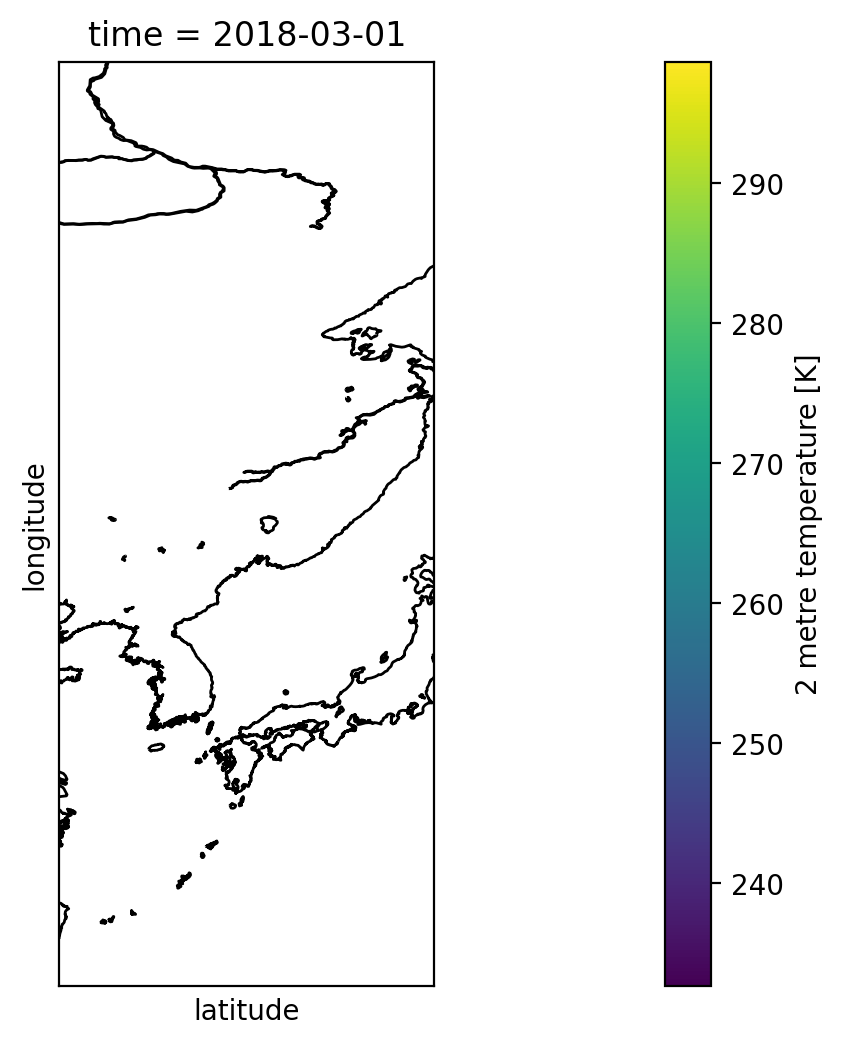

In [61]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (6,6) #차트 사이즈
from mpl_toolkits.basemap import Basemap, cm
m = Basemap(llcrnrlon=min(ds_kor.longitude),llcrnrlat=min(ds_kor.latitude),urcrnrlon=max(ds_kor.longitude),urcrnrlat=max(ds_kor.latitude), resolution='i',projection='cyl',lon_0=(max(ds_kor.longitude)-min(ds_kor.longitude)) / 2,lat_0=(max(ds_kor.latitude)-min(ds_kor.latitude)) / 2)
ds_kor.plot()
m.drawcoastlines()